# Optimizers

This notebook serves as a library of optimizers, as well as a set of test functions that evaluate optimizer performance



In [16]:
#check if the notebook is being used as a library, or being run as a notebook
asLibrary = lambda : '__file__' in globals()
if asLibrary():
    print("optimizers run as library")

## Define the the optimizer interface
to maitain a level of decoupling between elements of the software system, the optimizer will not be given access to the robot or the experiment explicitly, but will deal instead only with function handles for the objective function and constraint functions.

In [80]:
class Opt:
    """
    defines the interface that all types of optimizer should follow
    """
    def optimize(self,obj, constraints):
        """
        the function which actually performs the optimization or sampling
        inputs:
            obj - a function handle from exp.objective
            constraints - a function handle for r.getBoxConstraints
        outputs:
            x - a list of np.array objects, each of which is a solution
                list of the parameter for the optimal solution
        """
        pass


to do: 


In [ ]:
#define optimization interface here

In [529]:
from scipy.interpolate import interp1d
import plotly.graph_objs as go
import numpy as np

# objective function
class testObjFxn:
    def __init__(self):
        self.X = np.linspace(0,1,1000)
        self._y = np.asarray([self.objective(x) for x in self.X])
        self.f =  interp1d(self.X, self._y,kind='cubic')
        
    def objective(self,x, noise=0.1):
        noise = np.random.normal(loc=0, scale=noise)
        return (x**2 * np.sin(5 * np.pi * x)**6.0) + noise
    
    def pltSampleHistory(self,x,fx):
        n = len(x)
        
        #x vs. f(x)
        fig = go.Figure()
        fig.add_scatter(mode="markers", marker = dict(color = np.linspace(0,1,n)),name="Sample")
        fig.data[0]['x'] = x
        fig.data[0]['y'] = fx
        display(fig)
        
        
        #n vs fx
        fig2 = go.Figure()
        fig2.add_scatter(x=np.arange(0,n,1),y=fx,name="Sample")
        display(fig2)
        
        

### baysian optimization

#### resources
* https://gpflowopt.readthedocs.io/en/latest/notebooks/constrained_bo.html baysian optimization with constraints.



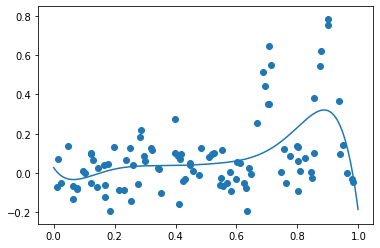

>x=0.879, f()=0.319885, actual=0.646
>x=0.886, f()=0.349377, actual=0.648
>x=0.890, f()=0.374332, actual=0.790
>x=0.896, f()=0.406509, actual=0.804
>x=0.896, f()=0.436562, actual=0.760
>x=0.908, f()=0.452599, actual=0.777
>x=0.898, f()=0.480957, actual=0.883
>x=0.897, f()=0.505890, actual=0.567
>x=0.897, f()=0.509377, actual=0.831
>x=0.919, f()=0.504093, actual=0.636
>x=0.899, f()=0.534229, actual=0.728
>x=0.855, f()=0.468300, actual=0.158
>x=0.901, f()=0.533489, actual=0.695
>x=0.902, f()=0.541073, actual=0.817
>x=0.925, f()=0.518471, actual=0.574
>x=0.885, f()=0.542721, actual=0.605
>x=0.900, f()=0.558270, actual=0.805
>x=0.585, f()=0.055370, actual=0.092
>x=0.915, f()=0.557236, actual=0.697
>x=0.912, f()=0.567963, actual=0.835
>x=0.897, f()=0.582123, actual=1.024
>x=0.885, f()=0.581165, actual=0.737
>x=0.898, f()=0.602989, actual=0.935
>x=0.926, f()=0.575893, actual=0.491
>x=0.902, f()=0.612545, actual=0.848
>x=0.919, f()=0.601585, actual=0.700
>x=0.899, f()=0.622078, actual=0.898
>

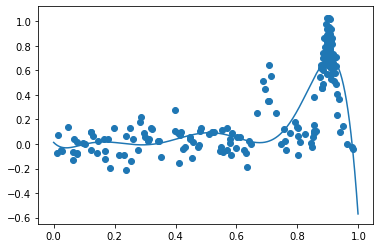

Best Result: x=0.905, y=1.026


In [23]:
# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

# objective function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return (x**2 * sin(5 * pi * x)**6.0) + noise

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # show the plot
    pyplot.show()
    

if not asLibrary():
    # sample the domain sparsely with noise
    X = random(100)
    y = asarray([objective(x) for x in X])
    # reshape into rows and cols
    X = X.reshape(len(X), 1)
    y = y.reshape(len(y), 1)
    # define the model
    model = GaussianProcessRegressor()
    # fit the model
    model.fit(X, y)
    # plot before hand
    plot(X, y, model)
    # perform the optimization process
    for i in range(100):
        # select the next point to sample
        x = opt_acquisition(X, y, model)
        # sample the point
        actual = objective(x)
        # summarize the finding
        est, _ = surrogate(model, [[x]])
        print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
        # add the data to the dataset
        X = vstack((X, [[x]]))
        y = vstack((y, [[actual]]))
        # update the model
        model.fit(X, y)

    # plot all samples and the final surrogate function
    plot(X, y, model)
    # best result
    ix = argmax(y)
    print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

### sobol sampling -  Nelder-Mead or Gradient Decent. 

the idea behind this approach is to evaluate:
1. if the function we are dealing with is convex, (in which case, all of the simplex methods will end up at the same place)
2. if it's not convex, are there local solutions that are interesting to consider (perhaps are less sensitive, or better in some way we didn't anticipate?) the idea would be to visually inspect these solutions for their quality.


#### refs:
https://people.sc.fsu.edu/~jburkardt/py_src/sobol/sobol.html

In [75]:
from sobol import i4_sobol
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objs as go

class SobolVis:
    """
    just want to get a sense for what sampling a unit space
    using sobol sampling looks like
    """
    def __init__(self):
        _fig = go.Figure(data=[go.Scatter3d(z=[0],x=[0],y=[0], name = "sampling",mode="markers",
                                            marker = dict(size=10,color = np.linspace(0,1,1000),showscale=True))])
        self.fig = go.FigureWidget(_fig)
        n = widgets.IntSlider(min=1,max=1000,value=1,description='samps')
        self.wdict = {"n":n}
        
        self.fig.update_layout(
            autosize=False,
            width = 800,
            height= 800,
            legend=dict(x=.025, y=.975),
            margin=dict(l=0, r=20, t=0, b=0))
        
    def genSamps(self,n):
        #how to use sobol
        dim_num = 11; seed = 0
        samps = [i4_sobol(dim_num, seed)[0] for seed in range(n)]
        samps = np.array(samps)
        xs = samps[:,0] ; ys = samps[:,1] ; zs = samps[:,2]
        return xs,ys,zs
    
    
    def update(self,n=1):
        fig = self.fig
        with fig.batch_update():
            #plot n sobol points, with coloring
            xs,ys,zs = self.genSamps(n)
            
            fig.data[0]['x']= xs
            fig.data[0]['y']= ys
            fig.data[0]['z']= zs
            
            
    def disp(self):
        self.out = widgets.interactive_output(self.update, self.wdict)
        display(self.wdict["n"])
        display(self.fig)
        

#interactive 3D sobol sampling visualization to get a sense of the algorithm 
if not asLibrary() and True:
    vis = SobolVis()
    vis.disp()

IntSlider(value=1, description='samps', max=1000, min=1)

FigureWidget({
    'data': [{'marker': {'color': array([0.      , 0.001001, 0.002002, ..., 0.997998, 0.998999,…

In [78]:
from sobol import i4_sobol
import ipywidgets as widgets
import numpy as np


class SobolSample:
    """
    discover interesting and good solutions at different locations within the space, 
    no optimization is performed strictly speaking, just structured exploration
    """
    def __init__(self):
        self.nSamps = 1000
        self.nBest = 10
        self.solutions = []
        self.bounds = bounds  #function handle to bounds? 
    
    
    def optimize(self,obj):
        """
        
        """
        self.solutions = np.zeros()
        for samp in self.nSamps: 
            pass
            
        
        
#note, the way this class is structured, you should be able to specify the number of points to be 1, and get a normal NM or GD solution. 

class SobolOpt:
    """
    the sobol opt class 
    """
    def __init__(self):
        pass

### Simulated Annealing

on iteration 0
on iteration 100
on iteration 200
on iteration 300
on iteration 400
on iteration 500
on iteration 600
on iteration 700
on iteration 800
on iteration 900
on iteration 1000
[0.90289564] [0.97818903]
[0.90289564]


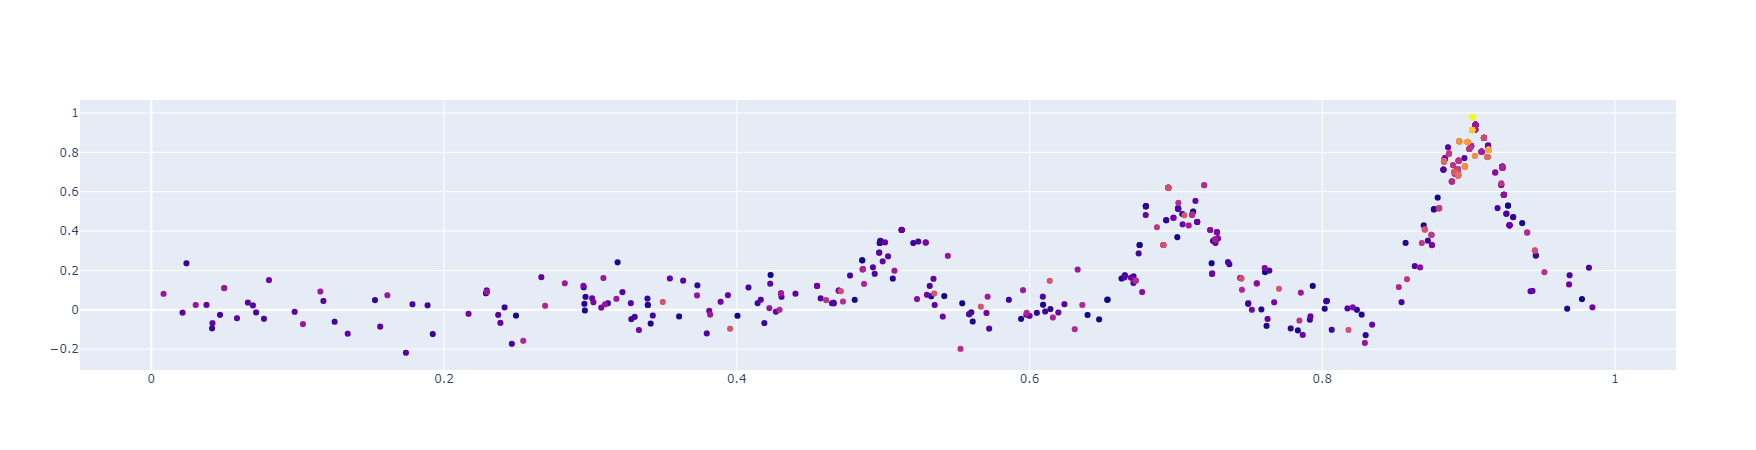

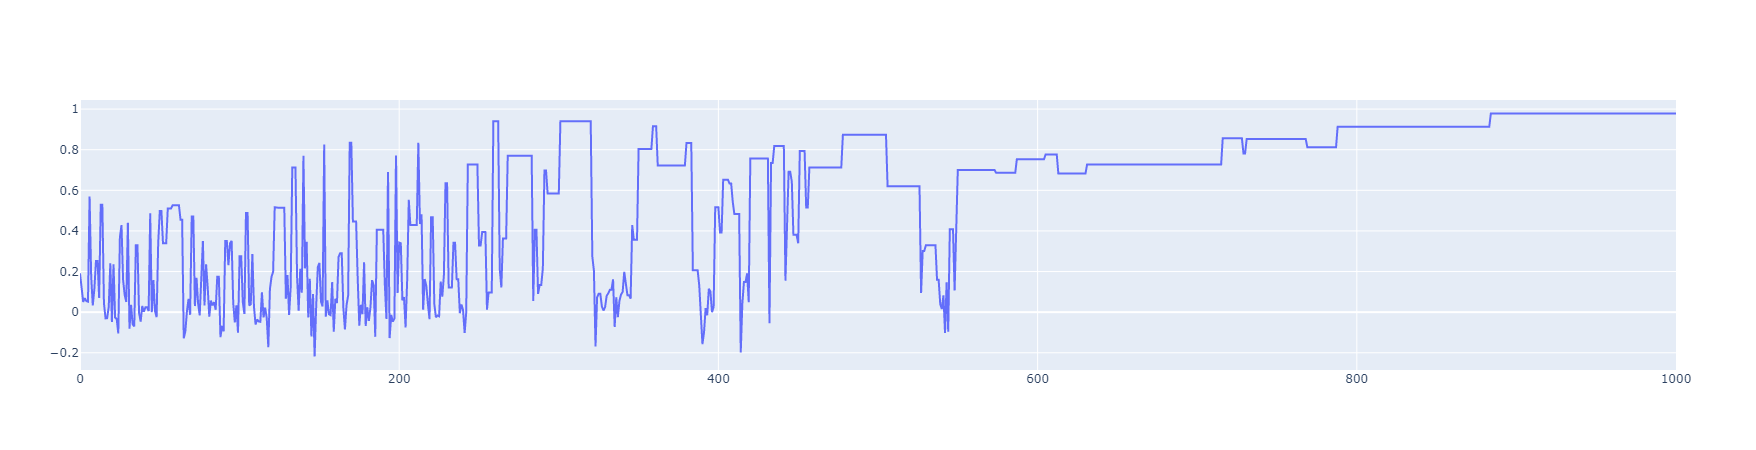

In [549]:
#simulated anealing algorithm must have the following functions: 
# the feasable state space
# the Energetic function (which is the objective function) E()
# the candidate generator procedure (neighbor(x))
#        -generation of random candidate vector, with variable magnitude?
#         aniostropic exploration is better!!!
#thoughts for how I might solve this problem - 
#         boundry check or only sampling within the boundry seems a good strategy. 
#        -moving in one direction at at time. 

# acceptance probability function P()
# anealing schedule - number, number of anealing cycles, cooling rate
# some termination condition - total execution time or number of interations
# presensce of and number of restarts, deterministic or otherwise? 

#of these, cooling schedule and neighbor seem the most important functions


class SA:
    def __init__(self):
        self.nIter = 1000;                     #total number of iterations to perform
        self.nResets = 3                       #number of resets to best 
        self.brt = self._brt()                 #trial numbers during which to reset to best
        self.dist = "uniform"                  #neighborhood sampling method 
        self.aMode = "exp"                     #Annealing mode ["exp","linear","stepped"]
        self.nMode = "linear"                  #neighborhood Mode
        self.T = 1                             #temperature variable on [1-0)
        self.N = 1                             #neighborhood size coefficient [1-0)
        self.C_half = 200                      #half-life cooling              [trials]
        self.N_half = 150                      #half-life of neighborhood size [trials]
        self.fxBest = 0                        #best encountered function value
        self.xBest = []                        #location of best value
        self.dbg = False                        #save variables for debugging
        self.xCache  = []                      #storage for x
        self.FxCache = []                      #storage for Fx
        self.updateReports = True              #should we print out an update of how the optimization is progressing?
        self.updateCount = 10                  #number of updates
        
        
    def setBoxConstraints(self,bcs):
        self.x_max = bcs[:,0]                  #upper limits on box constraints for x variable
        self.x_min = bcs[:,1]                  #lower limits on box constraints for x variable
        
    def _center(self,x_max,x_min):
        """
        find  the center of a box defined by limits
        """
        return [(x_max[i] + x_min[i])/2 for i in range(len(x_max))]
    
    def _twoPointLine(self,x,x1,y1,x2,y2):
        """
        returns y given the formula of a line specified in 2 point form
        """
        return ((y2-y1)/(x2-x1))*(x - x1) + y1
    
    def _brt(self):
        """
        calculate the best reset trials, evenly distribute in n_iter
        """
        return np.random.randint(low  = int(self.nIter/5),
                                 high = self.nIter,
                                 size = self.nResets)
        
            
    def sample(self,x):
        """
        sample the space for the next sample based on the neighborhood
        function
        input:
            x
        output:
            x_new
        """
        #define the (ever-shrinking) neighborhood bounding box
        w = self.N * ((self.x_max - self.x_min)/2) 
        nx_max = x + w
        nx_min = x - w
        
        #define the combined bounding box as an intersection between
        #the box constraints and the neighborhood box - a mini-max problem
        cx_max = np.amin(np.vstack((self.x_max,nx_max)),axis = 0)
        cx_min =  np.max(np.vstack((self.x_min,nx_min)),axis = 0)
        
#         for i in range(len(self.x_max)):
#             cx_max[i] = min(self.x_max,nx_max[i])
#             cx_min[i] = max(self.x_min,nx_min[i])
        
        #sample from the combined box, according to the appropriate distribution
        if self.dist == "uniform": 
            x_new = np.random.uniform(cx_min,cx_max) #vectorized
            
        if self.dist == "normal":
            pass
#             zScore = 1.645 #95% confidence interval
#             x_new = []
#             while len(x_new) > len(self.x_min):
#                 x = np.random.normal(loc=0.0, scale=1.0, size=None)
#                 if abs(x) < zScore:
#                     x_new.append(x)
#             c_range = cx_max - cx_min
            
 
        return x_new

    def optimize(self,obj,constraints):
        
        #set box constraints
        bcs = constraints()
        self.setBoxConstraints(bcs)
        
        #init x0 and fx0
        x0 =  self._center(self.x_max,self.x_min)
        fx0 = obj(x0)
        
        for n in range(self.nIter + 1):
            x = self.sample(x0)
            fx = obj(x)
            
            #if better, always keep
            if fx > fx0:
                x0 = x ; fx0 = fx
                
            #probabalistically accept worse answer
            else:
                Δf = fx - fx0
                r = np.random.random()
                if r < np.exp(Δf/self.T):
                    fx0 = fx ; x0 = x
                    #print(x)
                else:
                    pass
             
            
            #maintain best (for restarts, if used)
            if fx > self.fxBest:
                self.xBest = x  ; self.fxBest = fx 
                
            #do a best restart:
            if n in self.brt:
                  x0 = self.xBest ; fx0 = self.fxBest 
            
            #decrease temperature and neighborhood size
            if self.aMode == "exp": self.T = .5**(n/self.C_half)
            if self.nMode == "exp": self.N = .5**(n/self.N_half)
            
            if self.aMode == "Linear": self.T = self._twoPointLine(n,0,1,self.nIter,0)
            if self.nMode == "Linear": self.N = self._twoPointLine(n,0,1,self.nIter,0)
                
                  
            #store debugging vars
            if self.dbg:
                self.xCache.append(x0[0])
                self.FxCache.append(fx0[0])
                
            #give updates
            if self.updateReports:
                if n % ((self.nIter) / 10) == 0:
                    print("on iteration %d" %n)
        
        return x0
                    
 





if not asLibrary():
    #plot
    tester = testObjFxn()
    boxConstraints = np.array([[1,0]])
    sa = SA()
    sa.dbg = True
    sa.setBoxConstraints(boxConstraints)

    x0,fx0 = sa.optimize(tester.f)
    print(x0,fx0)
    print(sa.xBest)
    
    tester.pltSampleHistory(sa.xCache,sa.FxCache)
    
    #%timeit sa.optimize(tester.f)

# notes:

* instead of optimization per se, you could try something where you take the best solutions from a variety of locations within the space, so do a giant sobol sample on the space, and then choose the 100 best solutions that are the most different in terms of euclidian distance within the space, something like that. 
* I think we might want to add the ability to save general information within the picking process. so we could save an experiment like the one above. 